# 1. 载入数据

首先记得指明你的data_dir：

In [1]:
# data_dir = './data/self-built-masked-face-recognition-dataset/AFDB_face_dataset/'
data_dir = 'F:/Projects/FaceMaskDetection/RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset/'
masked_data_dir = 'F:/Projects/FaceMaskDetection/RMFD/self-built-masked-face-recognition-dataset/AFDB_masked_face_dataset/'

In [2]:
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *

In [3]:
X_list = []
y_list = []
labels = os.listdir(data_dir)
for label in labels:
    fns = os.listdir(data_dir + '/' + label)
    for fn in fns:
        X_list.append(data_dir + '/' + label + '/' + fn)
        y_list.append(label)

In [4]:
len(X_list)

90468

In [5]:
X_list[0]

'F:/Projects/FaceMaskDetection/RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset//aidai/0_0_aidai_0014.jpg'

In [6]:
y_list[0]

'aidai'

In [7]:
img_path = X_list[0]
size = 32
X = (cv2.resize(cv2.imread(img_path), (size, size))[:, :, ::-1].copy())

In [8]:
X.shape

(32, 32, 3)

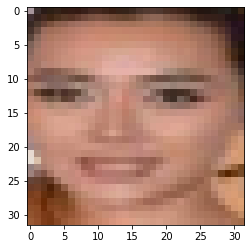

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X)

可以看到没有口罩的数据集中，一共是有460个不同的人。如果是之后还要用到有口罩的数据集，那里面是525人，最好取一下交集。

In [10]:
len(set(y_list))

460

**接下来在这里叠加有口罩的情况，注意我们只使用之前已经存在的人名，因为 没有口罩的总人数是460，而有口罩的总人数是525，我们取了交集，也就是只使用460个人的图片**

In [11]:
len(X_list)

90468

In [12]:
# 只使用之前已经有的460个人的图片
for label in set(y_list):
    try:
        fns = os.listdir(masked_data_dir + '/' + label)
        for fn in fns:
            X_list.append(masked_data_dir + '/' + label + '/' + fn)
            y_list.append(label)
    except:
        print(label, 'not exists')

hewenhui not exists
wangzhiwen not exists
liwen not exists
linyilun not exists
yufeihong not exists
fuxinbo not exists
hedujuan not exists
zhongjiaxin not exists
liupinyan not exists
yufeng not exists
hejunxiang not exists
zhangzhenyue not exists
liaofan not exists
gaohu not exists
hudie not exists
dongchengpeng not exists
tanlina not exists
linyilian not exists


In [13]:
len(X_list)

92413

**可以看到多了2000张图片。**下面的流程是类似的。

In [14]:
import pandas as pd
df = pd.DataFrame({'X': X_list, 'y_name': y_list}, index=range(len(X_list)))

In [15]:
df.head()

,X,y_name
0,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai
1,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai
2,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai
3,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai
4,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai


把y这个类别转换为数字编码的标签：

In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['y'] = encoder.fit_transform(df['y_name'])

In [17]:
df.head()

,X,y_name,y
0,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai,0
1,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai,0
2,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai,0
3,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai,0
4,F:/Projects/FaceMaskDetection/RMFD/self-built-...,aidai,0


In [18]:
max(df['y'])

459

In [19]:
num_classes = max(df['y']) + 1

接下来进行数据集的划分：

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 按照不同人进行分层采样
# 尽量避免有人只出现在训练集或只出现在测试集的情况
for train_index, test_index in split.split(df, df['y']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [21]:
strat_train_set.shape

(73930, 3)

In [22]:
strat_test_set.shape

(18483, 3)

In [23]:
df.shape

(92413, 3)

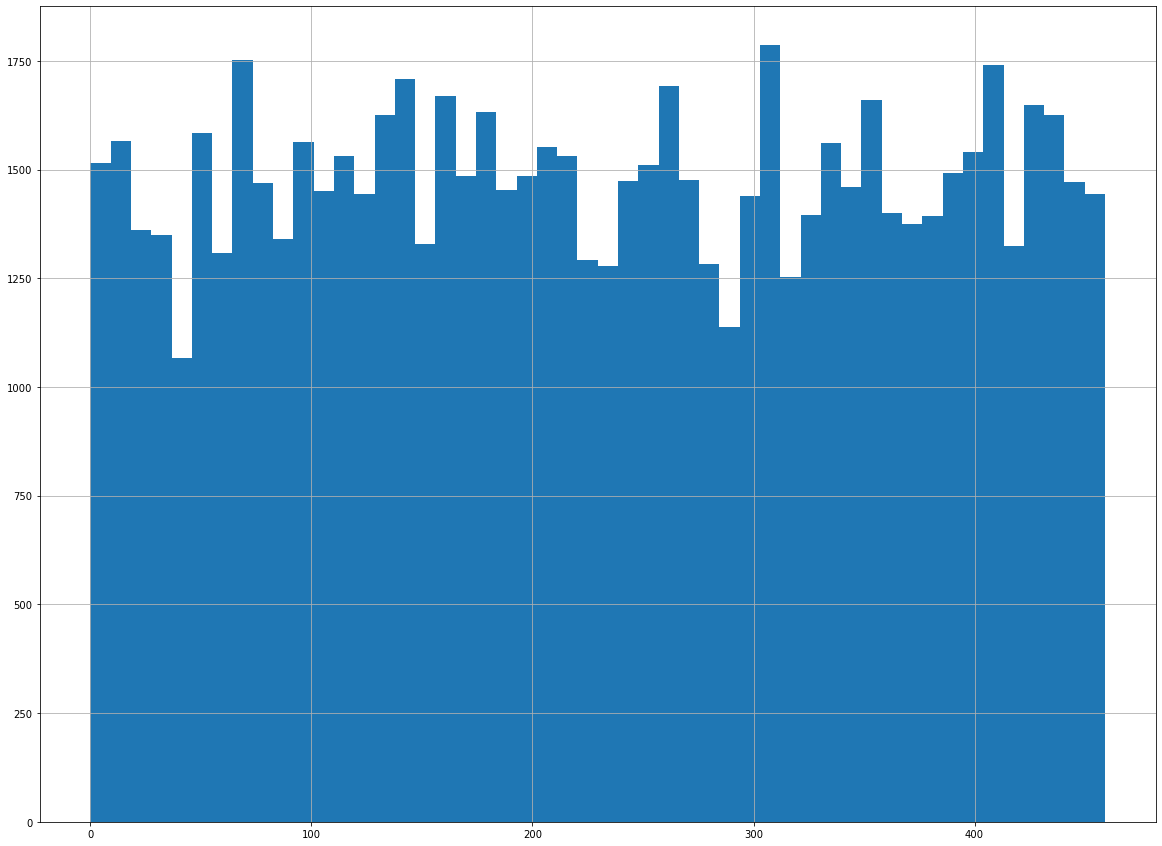

In [24]:
strat_train_set['y'].hist(bins=50, figsize=(20,15))

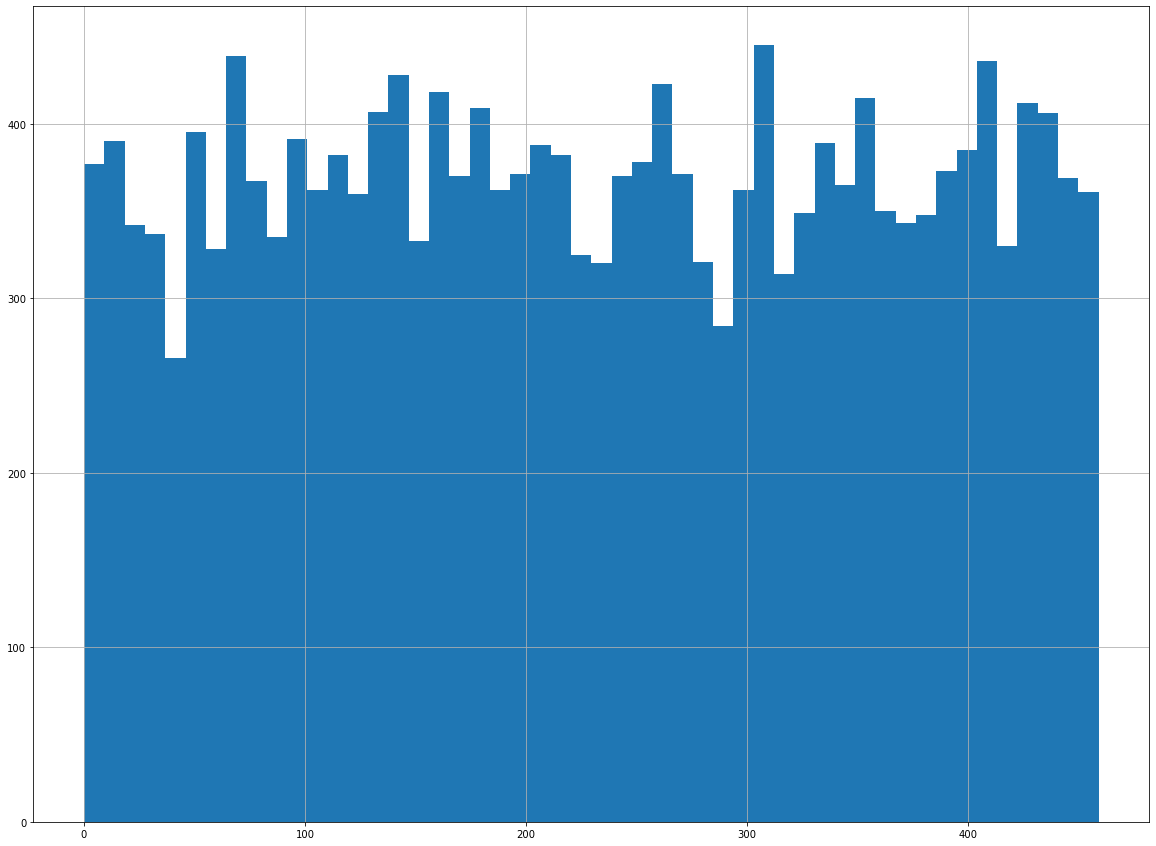

In [25]:
strat_test_set['y'].hist(bins=50, figsize=(20,15))

接下来利用ImageDataGenerator来准备训练用的generator

In [26]:
from keras_preprocessing.image import ImageDataGenerator

In [27]:
# 图像归一化
# 并且划分20%的训练集数据作为验证集数据
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 设置小批量的大小
batch_size = 16

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
train_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col='X',
                                            y_col='y_name',
                                            subset="training",
                                            seed=44,  # 随机数种子
                                            class_mode="sparse", # 直接使用文本标签
                                            target_size=(224, 224),  # 这里把图片变小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

# 划分
valid_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col='X',
                                            y_col='y_name',
                                            subset="validation",
                                            seed=44,  # 随机数种子
                                            class_mode="sparse", # 直接使用文本标签
                                            target_size=(224, 224),  # 这里把图片变小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

Found 59144 validated image filenames belonging to 460 classes.
Found 14786 validated image filenames belonging to 460 classes.


分布查看训练集和验证集的数据量：

In [28]:
train_generator.n

59144

In [29]:
train_generator.batch_size

16

In [30]:
valid_generator.n

14786

In [31]:
valid_generator.batch_size

16

In [32]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape)
    print(y_batch.shape)
    break

(16, 224, 224, 3)
(16,)


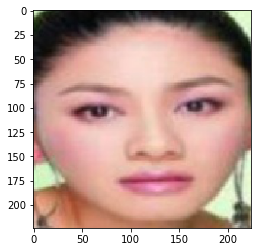

In [33]:
plt.imshow(X_batch[0])

In [34]:
y_batch[0]

114.0

可以看到已经train_generator已经可以自动读取图像了

类似的，我们构建test_generator

In [35]:
# 图像归一化
datagen=ImageDataGenerator(rescale=1./255)
batch_size = 16

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
test_generator=datagen.flow_from_dataframe(dataframe=strat_test_set, 
                                            x_col='X',
                                            y_col='y_name',
                                            class_mode="sparse", # 直接使用文本标签
                                            target_size=(224, 224),  # 这里把图片变小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

Found 18483 validated image filenames belonging to 460 classes.


In [36]:
test_generator.n

18483

In [37]:
test_generator.batch_size

16

# 2. 模型尝试

In [38]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# 不同电脑上keras配置文件最好都改成一致的，否则这里确认下
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

注意这里的输入是**(224, 224, 3)**

In [39]:
# 先设置一个base model
# 当我们使用预训练的权重时，必须要求输入3个通道，即RGB通道
base_model = DenseNet201(input_shape=(224, 224, 3),  # MobileNet要求输入的尺寸不小于32，不同模型有不同要求
                       include_top=False,  # 不使用最后一层，因为我们要按照具体的数据来设置最后一层的神经元个数
                       weights=None)  # 这里我们不使用预训练过的权重，如果使用，图片尺寸最好变更大

# 添加a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# 添加a fully-connected layer
x = Dense(1024, activation='relu')(x)

predictions = Dense(num_classes, activation='softmax')(x)

# 我们最终会训练的模型
net = Model(inputs=base_model.input, outputs=predictions)

进行模型的训练：

再加上early stopping进行过拟合的问题的处理：

In [40]:
# 这里的patience表示当10轮之后val_loss还是没有提高，就提前终止训练
from tensorflow import keras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

net.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

epochs = 50
batch_size = 16

history = net.fit(train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n // valid_generator.batch_size,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stop])

Epoch 1/50
3696/3696 [==============================] - 791s 214ms/step - loss: 5.6888 - accuracy: 0.0118 - val_loss: 5.2313 - val_accuracy: 0.0212
Epoch 2/50
3696/3696 [==============================] - 805s 218ms/step - loss: 4.8872 - accuracy: 0.0481 - val_loss: 5.2209 - val_accuracy: 0.0371
Epoch 3/50
3696/3696 [==============================] - 802s 217ms/step - loss: 4.1783 - accuracy: 0.1252 - val_loss: 4.5386 - val_accuracy: 0.0961
Epoch 4/50
3696/3696 [==============================] - 805s 218ms/step - loss: 3.5529 - accuracy: 0.2201 - val_loss: 4.1013 - val_accuracy: 0.1588
Epoch 5/50
3696/3696 [==============================] - 800s 216ms/step - loss: 2.9896 - accuracy: 0.3206 - val_loss: 3.3751 - val_accuracy: 0.2659
Epoch 6/50
3696/3696 [==============================] - 776s 210ms/step - loss: 2.4777 - accuracy: 0.4233 - val_loss: 3.3774 - val_accuracy: 0.2644
Epoch 7/50
3696/3696 [==============================] - 768s 208ms/step - loss: 2.0530 - accuracy: 0.5117 - val_

In [42]:
import matplotlib
%matplotlib inline

In [43]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Val Loss')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
             label = 'Val Accuracy')
    plt.legend()
    plt.show()

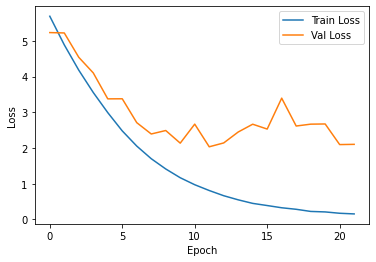

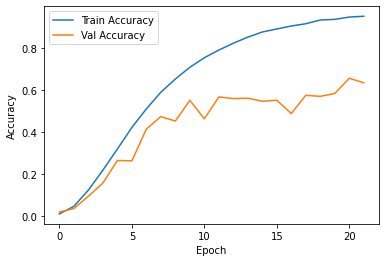

In [44]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(history)

In [45]:
loss, acc = net.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

1155/1155 [==============================] - 92s 79ms/step - loss: 2.1492 - accuracy: 0.6322


0.6321969628334045

接下来尝试 https://keras.io/api/applications/ 中列出的其他模型，注意有些模型对于输入的尺寸要求大于(32,32)，在使用的过程中要根据相应的报错信息或者模型的说明进行修改。

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

net.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

epochs = 50
batch_size = 8

history = net.fit(train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n // valid_generator.batch_size,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stop])

Epoch 1/50
3696/3696 [==============================] - 775s 210ms/step - loss: 0.0368 - accuracy: 0.9906 - val_loss: 1.3000 - val_accuracy: 0.7909
Epoch 2/50
3696/3696 [==============================] - 771s 209ms/step - loss: 0.0140 - accuracy: 0.9970 - val_loss: 1.2854 - val_accuracy: 0.7955
Epoch 3/50
3696/3696 [==============================] - 771s 209ms/step - loss: 0.0105 - accuracy: 0.9979 - val_loss: 1.2871 - val_accuracy: 0.7970
Epoch 4/50
3696/3696 [==============================] - 772s 209ms/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 1.2885 - val_accuracy: 0.7994
Epoch 5/50
3696/3696 [==============================] - 773s 209ms/step - loss: 0.0079 - accuracy: 0.9986 - val_loss: 1.2938 - val_accuracy: 0.8007
Epoch 6/50
3696/3696 [==============================] - 772s 209ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 1.2934 - val_accuracy: 0.8009
Epoch 7/50
3696/3696 [==============================] - 772s 209ms/step - loss: 0.0056 - accuracy: 0.9989 - val_

In [47]:
loss, acc = net.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

1155/1155 [==============================] - 63s 55ms/step - loss: 1.3331 - accuracy: 0.8012


0.8011904954910278